# The script does next:

### Open file $\to$ rotate $\to$ crop $\to$ preob $\to$ peaks $\to$ characteristic curve 

# Libraries

In [1]:
#VERSIONS OF LIBRARIES!!!!
#HOW OPEN ANACONDA

import numpy as np ###v1.20.3
import astropy###v4.3.1
from astropy.io import fits
import matplotlib.pyplot as plt###v3.4.3
import cv2 #!pip3 install opencv-python ###v4.5.5
from scipy import signal ### v1.7.1
from scipy.signal import find_peaks
from astropy.io import fits
from PIL import Image###v8.4.0
from skimage import io, color###V0.18.3
import math
from tkinter import *

# func 

In [2]:
def fits2png(filename):
    
    """
    The function open fits file and return PIL Image file for visualisation
    and array with initial data from fits file
    """ 
    data_fits = fits.open(f"{filename}")[0].data
    plt.imsave(f"{filename}.jpg",data_fits[::-1])

    return data_fits

In [3]:
def subimage_preob_1(name_file,data, x1,y1,x2,y2,x3,y3,x4,y4): #calib, center, theta, width, height):
    ''' 
    Rotates OpenCV image around center with angle theta (in deg)
    then crops the image according to width and height.
    '''
#     path = os.getcwd()#для просмотра корневой дирректории
    lina_color = io.imread(f'{name_file}')
    lina_gray = color.rgb2gray(lina_color)
 #открываем картинку (не повёрнута, не обрезана) # массив файла калибровки (наш o_call)
    difr= data/lina_gray
    lina_gray = lina_gray*difr
    for i in range(0,len(lina_gray)):
        for j in range(0,len(lina_gray[i])):
            lina_gray[i][j] = int(lina_gray[i][j])
            if lina_gray[i][j] != data[i][j]:
                lina_gray[i][j] = data[i][j]
    polygon_data = ((x1,y1), (x2, y2), (x3, y3), (x4, y4)) 
    center = centroid(polygon_data) #обращается к фукции centroid
    width = np.sqrt((x2-x1)**2+(y2-y1)**2)
    height = np.sqrt((x4-x1)**2+(y4-y1)**2)
    theta = math.atan2((x1-x2),(y1-y2))
    if center[0]<1 and center[1]<1 and width<1: #проверка на случай если мы работаем в относительных координатах и их пересчёт к абсолютным
        center_x = int(center[0]*lina_gray.shape[1])
        center_y = int(center[1]*lina_gray.shape[0])
        width = int(width * lina_gray.shape[1])
        height = int(height * lina_gray.shape[0])
        center = (center_x,center_y)
        
    shape = ( lina_gray.shape[1], lina_gray.shape[0] ) # cv2.warpAffine expects shape in (length, height)
    matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 ) #поворот матрицы вокруг указанного центра
    lina_gray = cv2.warpAffine(src=lina_gray, M=matrix, dsize=shape ) #сохранение повернутого изображения из матрицы

    x = int( center[0] - width/2  ) #поиск координаты x слева
    y = int( center[1] - height/2 ) # поиск координаты у снизу

    lina_gray = lina_gray[ y:int(y+height), x:int(x+width) ] #обрезка изображения по координатам
    
    #preob
    im_array = lina_gray# создаем из нее массив 
    array_log10 = np.log10(65536/im_array)*1000 #(257.003921569 = 65536/255), also data (смещение запятой)
    mean = array_log10.mean(axis=0) #среднее значение по столбцам
    
    
    plt.imshow(lina_gray) #path -- путь к корневой дирректории
    
    #возвращает обрезанное изображение
    return lina_gray,difr,lina_gray

In [4]:
def centroid(vertexes):
    x_list = [vertex[0] for vertex in vertexes]
    y_list = [vertex[1] for vertex in vertexes]
    lenth = len(vertexes)
    x = sum(x_list) / lenth
    y = sum(y_list) / lenth
    return(x, y)


In [5]:
def subimage_preob_2(name_file,data, x1,y1,x2,y2,x3,y3,x4,y4): #calib, center, theta, width, height):
    ''' 
    Rotates OpenCV image around center with angle theta (in deg)
    then crops the image according to width and height.
    '''
#     path = os.getcwd()#для просмотра корневой дирректории

#     shape1 = data.shape[1]
#     shape0 = data.shape[0]

#     x1= int((x1_prog) * shape1)
#     y1= int((1-y1_prog) * shape0)
#     x2= int((x2_prog) * shape1)
#     y2= int((1-y2_prog) * shape0)
#     x3= int((x3_prog) * shape1)
#     y3= int((1-y3_prog) * shape0)
#     x4= int((x4_prog) * shape1)
#     y4= int((1-y4_prog) * shape0)

    lina_color = io.imread(f'{name_file}')
    lina_gray = color.rgb2gray(lina_color)
    tan = (y2-y1)/(x2-x1)
    radian = math.atan2((y1-y2),(x1-x2))
    theta = radian*180/np.pi
    print(theta)
    if theta > 90:
        theta = -180 + theta
    elif theta < -90:
        theta = 180 + theta
    else:
        theta = theta
    print(theta)
    for i in range(0,len(data)):
        for j in range(0,len(data[i])):
            lina_gray[i][j] = data[i][j]
            
    polygon_data = ((x1,y1), (x2, y2), (x3, y3), (x4, y4)) 
    center = centroid(polygon_data) #обращается к фукции centroid
    width = np.sqrt((x2-x1)**2+(y2-y1)**2)
    height = np.sqrt((x4-x1)**2+(y4-y1)**2)
    if center[0]<1 and center[1]<1 and width<1: #проверка на случай если мы работаем в относительных координатах и их пересчёт к абсолютным
        center_x = int(center[0]*lina_gray.shape[1])
        center_y = int(center[1]*lina_gray.shape[0])
        width = int(width * lina_gray.shape[1])
        height = int(height * lina_gray.shape[0])
        center = (center_x,center_y)
        
    shape = ( data.shape[1], data.shape[0] ) # cv2.warpAffine expects shape in (length, height)
    matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 ) #поворот матрицы вокруг указанного центра
    lina_rotated = cv2.warpAffine(src=lina_gray, M=matrix, dsize=shape ) #сохранение повернутого изображения из матрицы

    x = int( center[0] - width/2  ) #поиск координаты x слева
    y = int( center[1] - height/2 ) # поиск координаты у снизу

    lina_croped = lina_rotated[ y:int(y+height), x:int(x+width) ] #обрезка изображения по координатам
    
    #preob
    array_log10 = np.log10(65536/lina_croped)*1000 #(257.003921569 = 65536/255), also data (смещение запятой)
    mean = array_log10.mean(axis=0) #среднее значение по столбцам
    
    
    plt.imshow(lina_croped) #path -- путь к корневой дирректории
    plt.gca().invert_yaxis()
    #возвращает обрезанное изображение
    return lina_croped,mean

In [34]:
def peaks(mean,order):
    """
    function for searching peaks in array 
    """
    peak_indexes = signal.argrelextrema(mean, np.greater, order=order)[0] #индексы пиков 
    peak_mean =[] # создаем пустой массив для средних значений пиков
    for i in range(0,len(mean)):
        if i in peak_indexes:
            peak_mean.append((mean[i-2]+mean[i-1]+mean[i]+mean[i+1]+mean[i+2])/5) # ищем среднее по пяти рядом стоящих значений
    #возвращает позицию/индекс найденного пика и среднее значение по пяти значениям : пик + 2 слева + 2 справа
    return peak_indexes,peak_mean

In [7]:
def peaks_our(mean):    
    
    for ind,p in enumerate(mean): 
        
        if p < mean[ind+1]:
            continue
        
        else:
            first_peak_ind = ind
            break

    random_peak_ind=[first_peak_ind]
    
    for ind in range(first_peak_ind+1,len(mean)-1):
        
        if mean[ind] > mean[ind-1] and mean[ind] > mean[ind+1]:
            random_peak_ind.append(ind)
            
    bad_peaks = []
    good_peaks = []
    min_dist = 10
    counter = 0
    
    for ind in range(0,len(random_peak_ind)-1):
        delta = random_peak_ind[ind+1] - random_peak_ind[ind]
        
        if delta < min_dist:
            bad_peaks.append(random_peak_ind[ind])
            bad_peaks.append(random_peak_ind[ind+1])
        
        else:
            
            if len(bad_peaks)==0:
                good_peaks.append(random_peak_ind[ind])
            
            else:
                bad_peaks = np.array(np.unique(bad_peaks))
                mean_index = int(bad_peaks.mean())
                good_peaks.append(mean_index)
                bad_peaks = []

    good_peaks.append(random_peak_ind[-1])
    
    if len(good_peaks) > 9:
        
        if mean[[good_peaks[-1]]] < mean[[good_peaks[-2]]]:
            good_peaks = good_peaks[:-1] 
            
    peak_mean =[] # создаем пустой массив для средних значений пиков
    for i in range(0,len(mean)):
        if i in good_peaks:
            peak_mean.append((mean[i-2]+mean[i-1]+mean[i]+mean[i+1]+mean[i+2])/5) # ищем среднее по пяти рядом стоящих значений
    #возвращает позицию/индекс найденного пика и среднее значение по пяти значениям : пик + 2 слева + 2 справа        

    return good_peaks, peak_mean                    

In [8]:
def aprx1(x,y,order):

    monotone = False
    while monotone == False:
        
        z = np.polyfit( x,y,order)
        p = np.poly1d(z)
        xp = np.linspace(0, x[-1], 1000)
        # print(xp)
        pxp = p(xp)

        for i in range(1,len(pxp)):
            max_pxp = y[:-1].max()
            if pxp[i]<=pxp[i-1]:
                pxp[i]=pxp[i-1]+1
                if pxp[i]>=max_pxp:
                    min_pxp = pxp[i-100]
                    delta_pxp = abs((max_pxp - min_pxp)/(len(pxp)-i-1))
                    index = i-10
                    break


        for j in range(index+1,len(pxp)):
            pxp[j]=pxp[j-1]+delta_pxp

        z = np.polyfit( xp,pxp, 6)
        pp = np.poly1d(z)
        xpp = np.linspace(0, x[-1], 1000)

        pxpp = pp(xpp)
        
        check = []
        for k in range(0,len(pxpp)-1):      
            if pxpp[k]>pxpp[k+1]:
                check.append(k)
        
        if len(check) == 0:
                monotone = True
        else:
            order = order+1
            monotone = False
               
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=80)
    ax1 = plt.scatter(x[:-1],y[:-1], color="blue",s=5) 
    ax1 = plt.plot(xp, p(xp), color="orange")           

    fig, ax2 = plt.subplots(figsize=(6,4),dpi=120)
    ax2 = plt.plot( xpp, pp(xpp), lw=1, label = f"Апроксимация полиномом ({order},6)")#"Polynomial approximation")
    ax2 = plt.scatter(x[:-1],y[:-1], color="red",s=50,marker='.')#, label = "Attenuator magnitude")
    plt.legend()
    plt.xlabel("Интенсивность")
    plt.ylabel("Почернение")
#     plt.yticks([200, 300, 400, 500, 600, 700, 800, 900])
    plt.savefig("characteristic_curve.jpg")
    return xpp,pp

In [9]:
def aprx2(x,y,order):

    # monotone = False
        
    z = np.polyfit( x,y,order)
    p = np.poly1d(z)
    xp = np.linspace(x[0], x[-1], 1000)
    # print(xp)
    pxp = p(xp)

    for i in range(1,len(pxp)):
        max_pxp = y[:-1].max()
        if pxp[i]<=pxp[i-1]:
            pxp[i]=pxp[i-1]+1
            if pxp[i]>=max_pxp:
                min_pxp = pxp[i-100]
                delta_pxp = abs((max_pxp - min_pxp)/(len(pxp)-i-1))
                index = i-10
                break


    for j in range(index+1,len(pxp)):
        pxp[j]=pxp[j-1]+delta_pxp
               
    fig, ax1 = plt.subplots(figsize=(6,4),dpi=120)
    ax1 = plt.scatter(x,y, color="blue",s=50) 
    ax1 = plt.plot(xp, p(xp), color="orange",lw=2,label=f"Полином ({order})")   
    plt.legend()
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    plt.savefig("delta_lamd_polinomial.jpg")
    
    return xp,p

In [10]:
def mean_deviation(x_array,y_array):

    c = []
    for i in range(1,len(y_array)):
        c.append(abs(y_array[i] - y_array[i-1]))
    mean_deviation = np.array(c).sum()/len(y_array)

    #now we sort our data: if delta between neighboring elements larger than 2 mean deveation we will remove it
    indexes = []
    for i in range(1,len(y_array)):
        if abs(y_array[i]-y_array[i-1])>mean_deviation*2:
            indexes.append(i)

    y_array = np.delete(y_array,indexes)
    x_array = np.delete(x_array,indexes)
    xarray_flux = 10000/10**(x_array/2.5)
    a = []
    for i in range(0,len(xarray_flux)):
        a.append([xarray_flux[i],y_array[i]])

    a.sort(key=lambda x:x[0])

    xarray_flux = []
    y_array = []

    for i in range(0,len(a)):
        xarray_flux.append(a[i][0])
        y_array.append(a[i][1])

    xarray_flux = np.array(xarray_flux)
    y_array = np.array(y_array)       
    del a
    
    plt.figure(figsize=(6,4),dpi=120)
    plt.plot(xarray_flux, y_array, markersize=3,marker='o' )
    plt.xlabel("Интенсивность")
    plt.ylabel("Почернение")
#     plt.savefig("characteristic_curve_first.jpg")
    
    return xarray_flux, y_array

In [11]:
def polynomial_alighn(data,low_limit,up_limit,order):
    
    """
    function aligns the spectrum through finding min value in each column and approximate it with polynomial and mean for polinomial line
    
    data - whole image
    up_limit,low_limit - limits of spectra in rows number
    order - polinomial order to approximate spectra
    
    """
    
    data_part = data[low_limit:up_limit]
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=100)
    ax1.imshow(data_part, cmap='gray')
#     plt.imsave('pic_lamp_20s.jpg', data_part)
    ax1.set_title("Initial part of spectra")
#     plt.savefig("initial_part.eps")
    
    #create massive of part of whole spectra with arrays of columns, not rows
    data_columns = []
    for i in range(0,len(data_part[0])):
        data_columns.append(list(data_part[:,i]))
    data_columns=list(data_columns)
    
    #create massive of whole spectra with arrays of columns, not rows
    data_collumns_entire_image = []
    for j in range(0,len(data[0])):
        data_collumns_entire_image.append(list(data[:,j]))
    data_collumns_entire_image=list(data_collumns_entire_image)

    #find min value in each column and then find indexes of the values - they will be Y-coordinate
    data_col_min = data_part.min(axis=0)
    index = []
    for i in range(0,len(data_col_min)):
            index.append(data_columns[i].index(data_col_min[i]))


    #find median value of neighboring indexes of min values in each column in some ranges to compairing in the next steps
    #we schould find mediam values for ranges not for whole image, because we have non-linear graph and it has curvature  
    median = []
    n = 0
    while n+100<len(index):
        k=n+100
        median.append([n,k,np.median(index[n:k])])
        n=k
    else:
        median.append([n,-1,np.median(index[n:])])

    #calculate mean delta between neighboring values
    delt=[]
    for i in range(1,len(index)):
        delt.append(abs(index[i]-index[i-1]))
    delt_mean = np.array(delt).sum()/len(delt)    

    #now we compair difference between median value indexes of minimum value in each column     
    for i in median:
        for j in range(i[0],i[1]):
            if abs(i[2]-index[j])>delt_mean:
                index[j] = i[2]

    fig, ax2 = plt.subplots(figsize=(8,5),dpi=100)
    ax2.plot(index)
    
    #plot polynomial
    xp = np.arange(0,len(index))
    z = np.polyfit(xp,index, order)
    polynomial = np.poly1d(z)
    y_polynomial = polynomial(xp)
    ax2.plot(index, color="steelblue", label="Srectra line") 
    ax2.plot(xp, y_polynomial, color="orange", label=f"Polinomial, order = {order}")
    ax2.set_title("Polinomial approximation of spectra")
    ax2.legend()
#     plt.savefig("polinomial_spectra.eps")
    
    xp_tg = np.arange(0,len(y_polynomial))
    z_tg = np.polyfit(xp_tg,y_polynomial, 1)
    polynomial_tg = np.poly1d(z_tg)
    y_polynomial_tg = polynomial_tg(xp_tg)
    tg = polynomial_tg[1]
    
    #now we will plot our curve on our frame
    mean_polynomial = y_polynomial.mean()
    fig, ax3 = plt.subplots(figsize=(8,5),dpi=100)
    ax3.imshow(data_part, cmap='gray')
    ax3.plot(xp, y_polynomial, color="orange", label=f"Polinomial, order = {order}")
    ax3.axhline(mean_polynomial, label="Polinomial mean")
#     ax3.legend(bbox_to_anchor=(1.01,0.5))
#     plt.savefig("polinomial_mean.eps")
    
    delta_y = []
    for i in range(0,len(index)):
        delta = mean_polynomial - polynomial(xp)[i]
        delta_y.append(int(delta))

    shape = np.array(data_collumns_entire_image).shape
    new_pic_col = np.zeros(shape)
    for i in range(0,len(data_collumns_entire_image)):
        for j in range(0,len(data_collumns_entire_image[i])):
            m  = j + delta_y[i]
            if m<len(data_collumns_entire_image[i]):
                new_pic_col[i][m] = data_collumns_entire_image[i][j] 
            else:
                m = m - len(data_collumns_entire_image[i])
                new_pic_col[i][m] = data_collumns_entire_image[i][j] 
    data_rows = []
    for i in range(0,len(new_pic_col[0])):
        data_rows.append(list(new_pic_col[:,i]))
            
    
    delta_x = np.arange(0,len(data_rows))*tg
    shape = np.array(data_rows).shape
    new_data_rows = np.zeros(shape)
    for i in range(0,len(data_rows)):
        for j in range(0,len(data_rows[i])):
            m  = int(j + 2*delta_x[i])
            if m<len(data_rows[i]):
                new_data_rows[i][m] = data_rows[i][j] 
            else:
                m = m - len(data_rows[i])
                new_data_rows[i][m] = data_rows[i][j] 
    
    aligned_image = new_data_rows
    
    fig, ax4 = plt.subplots(figsize=(8,5),dpi=100)
    ax4.imshow(aligned_image, cmap='gray')
    ax4.grid()
    ax4.set_title("Aligned spectra 1st")
    #_________________________________________________________________________
    
    plt.savefig("aligned_spectra.eps")
    plt.savefig("aligned_spectra.jpg")
    
    
    return aligned_image

In [12]:
def preob_spectra(spectra):
    
    """
    Функция пересчитывает плотности почернения в интенсивности при помощи полинома, полученного 
    в работе с калибровками.
    На выходе преобразованный спектр и график, из которого необходимо определить на каких строках (х1 и х1) находится спектр.
    Тут же можно определить где находятся лампы.
    """
    x_log = (np.log10(65535/spectra) * 1000)
#     spectra_ = (2.803e-20*x_log**6 - 5.835e-16*x_log**5 + 1.635e-12*x_log**4 + 4.247e-08*x_log**3 - 0.0004067*x_log**2 + 1.439*x_log + 196.7).sum()
    
    spectra_ = polinomial(x_log)
#     
    sum_intens_row = spectra_.sum(axis=1)
    
    plt.figure(figsize=(6,4),dpi=120)
    plt.plot(sum_intens_row)
#     plt.grid(lw=0.1)
    plt.xlabel("Номер строки пикселей")
    plt.ylabel("Сумма интенсивностей")
#     plt.savefig("spectra_background_row1972s.jpeg")
    return spectra_

In [13]:
def spectra_lamps(data,y1,y2,y3,y4,y5,y6):
    
    """
    Функция для вырезания из целого изображения спектра двух ламп и
    спектра самого объекта по отдельнсти.
    """
    
    lamp_1 = data[y1:y2]
    spectra = data[y3:y4]
    lamp_2 = data[y5:y6]
    
    
    fig, ax1 = plt.subplots(figsize=(10,8),dpi=120)
    ax1.imshow(lamp_1)
    ax1.set_title("lamp1")
    
    
    fig, ax2 = plt.subplots(figsize=(10,8),dpi=120)
    ax2.imshow(spectra)
    ax2.set_title("spectra")

    fig, ax3 = plt.subplots(figsize=(10,8),dpi=120)
    ax3.imshow(lamp_2)
    ax3.set_title("lamp2")

    
    fig, ax4 = plt.subplots(figsize=(10,8),dpi=120)
    ax4.imshow(data)
    ax4.set_title("data")
    ax4.axhline(y1,c="r",lw=1)
    ax4.axhline(y2,c="r",lw=1)
    ax4.axhline(y3,c="b",lw=1)
    ax4.axhline(y4,c="b",lw=1)
    ax4.axhline(y5,c="r",lw=1)
    ax4.axhline(y6,c="r",lw=1)
    
    return lamp_1, spectra, lamp_2

In [14]:
def spectra_background(data,x1,x2):
    
    """
    Разбивает часть изображения со спектром на фон (над и под) и спектр.
    Вычитает фон из спектра и 
    на выходе выдает ГОТОВЫЙ спектр (+график, конечно же)
    """
    
    back_1 = data[0:x1]
    back_2 = data[x2:]
    back = np.concatenate((back_1,back_2))
    back_mean = back.mean(axis=0)
    
    spectrum = data[x1:x2]
    spectrum_sum = np.array(spectrum).sum(axis=0)
    spectrum_final = spectrum_sum - back_mean*(x2-x1)
    
    plt.figure(figsize=(8,4),dpi=120)
    plt.plot(spectrum_final)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("Интенсивность")
#     plt.savefig("spectra_obj_back.jpg")
    
    return spectrum_final

In [15]:
def standart_deviation(list_value):
    mean = np.mean(list_value)
    summ = []
    for i in list_value:
        summ.append((i-mean)**2)
    std = np.sqrt(np.sum(summ)/len(list_value))
    return std

def x_axis_to_wavelenght(lamp_1,lamp_2):
    
    lamp_1_std = standart_deviation(lamp_1)*0.5
    
    index_l_1 = []
    
    for i in range(1,len(lamp_1)-1):
        if lamp_1[i] > lamp_1_std and lamp_1[i] > lamp_1[i+1] and lamp_1[i] > lamp_1[i-1]:
            index_l_1.append(i)
     
    dalta_ind_l1 = []
    for i in range(1,len(index_l_1)):
        dalta_ind_l1.append(index_l_1[i]-index_l_1[i-1])
    delta_std_l1 = standart_deviation(dalta_ind_l1)
    
    index_l1 = []
    counter_l1 = 0 
    for i in range(0,len(index_l_1)):
            
            if counter_l1 == 0:
                index_l1.append(index_l_1[i])
                countr_l1 =+ 1
           
            else:
                d = index_l_1[i] - index_l_1[i-1]
                countr_l1 =+ 1
                if d < delta_std_l1:
                    index_l1.append(index_l_1[i])  
    
    
    index_l1_1 = index_l1[0]
    index_l1_2 = index_l1[-1]
    
    lamp_2_std = standart_deviation(lamp_2)
    
    index_l_2 = []
    for i in range(1,len(lamp_2)-1):
        if lamp_2[i] > lamp_2_std and lamp_2[i] > lamp_2[i+1] and lamp_2[i] > lamp_2[i-1]:
            index_l_2.append(i)
            
        
    dalta_ind_l2 = []
    for i in range(1,len(index_l_2)):
        dalta_ind_l2.append(index_l_2[i]-index_l_2[i-1])
    delta_std_l2 = standart_deviation(dalta_ind_l2)
    
    index_l2 = []
    counter_l2 = 0 
    for i in range(0,len(index_l_2)):
            
            if counter_l2 == 0:
                index_l2.append(index_l_2[i])
                countr_l2 =+ 1
           
            else:
                d = index_l_2[i] - index_l_2[i-1]
                countr_l2 =+ 1
                if d < delta_std_l2:
                    index_l2.append(index_l_2[i])          
            
            
    index_l2_1 = index_l2[0]
    index_l2_2 = index_l2[-2]
    
    index_1 = int(np.mean([index_l1_1,index_l2_1]))
    index_2 = int(np.mean([index_l1_2,index_l2_2]))
    

    #PLOT
    fig,(ax1,ax2) = plt.subplots(2,figsize=(8,4),dpi=120)
#     ax1.figure(figsize=(18,9))
    ax1.plot(lamp_1,label="Лампа 1")
    ax1.axhline(lamp_1_std,c="gray",lw=1)
    ax1.axvline(index_l1_1,c="r",lw=1)
    ax1.axvline(index_l1_2,c="r",lw=1)
    # ax1.scatter(index_l1_1, lamp_1[index_l1_1],c="r",s=83)
    # ax1.scatter(index_l1_2, lamp_1[index_l1_2],c="r",s=83)
    ax1.scatter(index_l1, lamp_1[index_l1],c="g")
#     ax1.set_title("Lamp 1")
    ax1.legend(loc=2)
    ax1.set_xlabel("Номер столбца пикселей")
    ax1.set_ylabel("Интенсивность")
    
    ax2.plot(lamp_2,label="Лампа 2")
    ax2.axhline(lamp_2_std,c="gray",lw=1)
    ax2.axvline(index_l2_1,c="r",lw=1)
    ax2.axvline(index_l2_2,c="r",lw=1)    
    # ax2.scatter(index_l2_1, lamp_2[index_l2_1],c="r",s=83)
    # ax2.scatter(index_l2_2, lamp_2[index_l2_2],c="r",s=83)    
    ax2.scatter(index_l2, lamp_2[index_l2],c="g")
#     ax2.set_title("Lamp 2")
    ax2.legend(loc=2)
    
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("Интенсивность")
    plt.savefig("wavelenght_lamp.jpg")
    
    return index_1,index_2, index_l1,index_l2

In [16]:
def pixel2wavelenght(spectra,lambd_0,lambd_n,N_0,N_n):
    
    """
    Function calculates mean dispersion of wavelenghts
    and convert numbers of columns to wavelenght using lamp spectra.
    
    spectra -- final spectra of object/lamp without background (1-d array)
    lambd_0 -- the wavelengths of the first line of lamp spectra in angstroms 
    lambd_n -- the wavelengths of the last line of lamp spectra in angstroms
    N_0 -- column number of the first line
    N_n -- column number of the last line
    """
    dispersion = (lambd_n - lambd_0)/(N_n - N_0)
    wavelenght = []
    
    for i in range(0,len(spectra)):
        delta = i - N_0
        wl = delta * dispersion #distance in angstrom between a column and first line column
        wavelenght.append(lambd_0+wl)
        
        #PLOT
    plt.figure(figsize=(18,9))
    plt.plot(wavelenght,spectra)
    
    return wavelenght,dispersion

In [17]:
def func(index_1,index_2,x1,x2,x3,x4,x5,lambd_1,lambd_2,lambd_3,lambd_4,lambd_5,wavelenght):
    
    delta_lambd_1 = wavelenght[x1] - lambd_1 
    delta_lambd_2 = wavelenght[x2] - lambd_2 
    delta_lambd_3 = wavelenght[x3] - lambd_3 
    delta_lambd_4 = wavelenght[x4] - lambd_4 
    delta_lambd_5 = wavelenght[x5] - lambd_5 
    
    print(wavelenght[x2])
    
    corr = np.array([0,delta_lambd_1,delta_lambd_2,delta_lambd_3,delta_lambd_4,delta_lambd_5,0]) #0 in the begging and in the end because we exactly know wavelenght of index_1,index_2
    
    plt.figure(figsize=(6,4), dpi=120)
    plt.scatter([index_1,x1,x2,x3,x4,x5,index_2],corr,s=50)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    plt.savefig("delta_lamd.jpg")
    xpp, polinomial = aprx2([index_1,x1,x2,x3,x4,x5,index_2],corr,3)
    
    columns = np.arange(0,len(wavelenght))
    
    correction_whole = np.array(polinomial(columns))
    
    wavelenght_corrected = wavelenght + correction_whole
    
    return wavelenght_corrected,polinomial

In [18]:
def graf(data, order):
    fig = plt.figure(figsize=(8,6),dpi = 100)
    ax1 = fig.add_subplot(2,1,1)
    x = np.arange(1, len(data) + 1)
    ax1.scatter(x,data,color = 'orangered', s = 2, alpha = 0.5)
    ax1.set_xlabel("Pixel")
    ax1.set_ylabel("Value of pixel")

    peak_indexes,peak_mean = peaks(data,order=order) #func_peaks
    ax2 = fig.add_subplot(2,1,2)
    x1 = np.arange(0,len(data))
    ax2.plot(x1,data)
    ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'maxima')
    ax2.scatter(peak_indexes, peak_mean, color = 'r', s = 10, marker = 'D', label = 'maxima')
    ax2.set_xlabel("Pixel")
    ax2.set_ylabel("Value of pixel")
    
    return peak_indexes,peak_mean

In [19]:
mag_before_1972 = [0,0.61,1.1,1.47,1.84,2.25,2.66,3.04,0]
mag_after_1972 = [0,0.5,0.97,1.44,1.93,2.43,2.69,3.04,0]

# spec red

# CALIB 16-1 3200dpi

In [20]:
data_call3s = fits2png("/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_3s_XVI-1.fit.fits")
data_call5s = fits2png("/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_5s_XVI-1.fit.fits")
data_call10s = fits2png("/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_10s_XVI-1.fit.fits")
data_call15s = fits2png("/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_15s_XVI-1.fit.fits")
data_call20s = fits2png("/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_20s_XVI-1.fit.fits")
data_call40s = fits2png("/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_40s_XVI-1.fit.fits")
data_call60s = fits2png("/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_60s_XVI-1.fit.fits")

o_call3s = np.array(data_call3s)
o_call5s = np.array(data_call5s)
o_call10s = np.array(data_call10s)
o_call15s = np.array(data_call15s)
o_call20s = np.array(data_call20s)
o_call40s = np.array(data_call40s)
o_call60s = np.array(data_call60s)

166.19687550591868
-13.803124494081317


<ipython-input-18-8320d7e59a14>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'maxima')


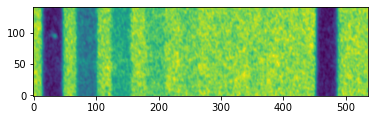

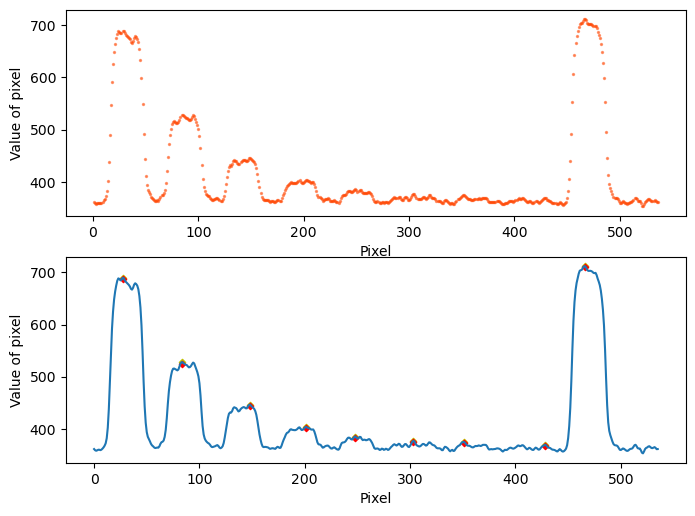

In [21]:
shape1 = o_call3s.shape[1]
shape0 = o_call3s.shape[0]

x1= int((0.336) * shape1)
y1= int((1-0.497) * shape0)
x2= int((0.621) * shape1)
y2= int((1-0.603) * shape0)
x3= int((0.66) * shape1)
y3= int((1-0.497) * shape0)
x4= int((0.375) * shape1)
y4= int((1-0.395) * shape0)

image_3s,mean_3s= subimage_preob_2('/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_3s_XVI-1.fit.fits.jpg',o_call3s,x1,y1,x2,y2,x3,y3,x4,y4)
peak_indexes_3s,peak_mean_3s = graf(mean_3s,21)


-13.304501775262052
-13.304501775262052


<ipython-input-18-8320d7e59a14>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'maxima')


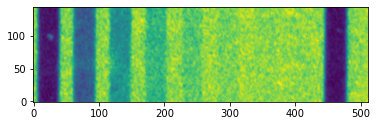

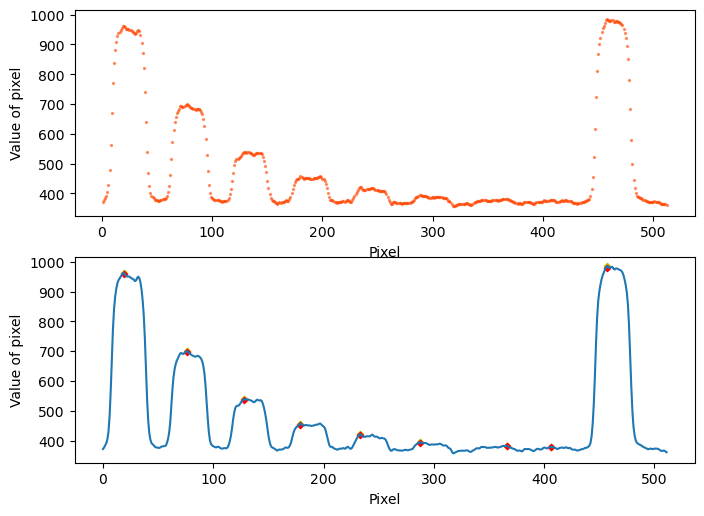

In [22]:
shape1 = o_call5s.shape[1]
shape0 = o_call5s.shape[0]

x1= int((0.639) * shape1)
y1= int((1-0.585) * shape0)
x2= int((0.366) * shape1)
y2= int((1-0.487) * shape0)
x3= int((0.403) * shape1)
y3= int((1-0.382) * shape0)
x4= int((0.677) * shape1)
y4= int((1-0.479) * shape0)

image_5s,mean_5s= subimage_preob_2('/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_5s_XVI-1.fit.fits.jpg',o_call5s,x1,y1,x2,y2,x3,y3,x4,y4)
peak_indexes_5s,peak_mean_5s = graf(mean_5s,21)


165.04710227568825
-14.952897724311754


<ipython-input-18-8320d7e59a14>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'maxima')


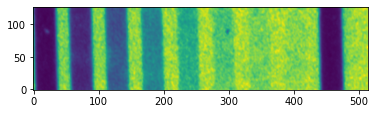

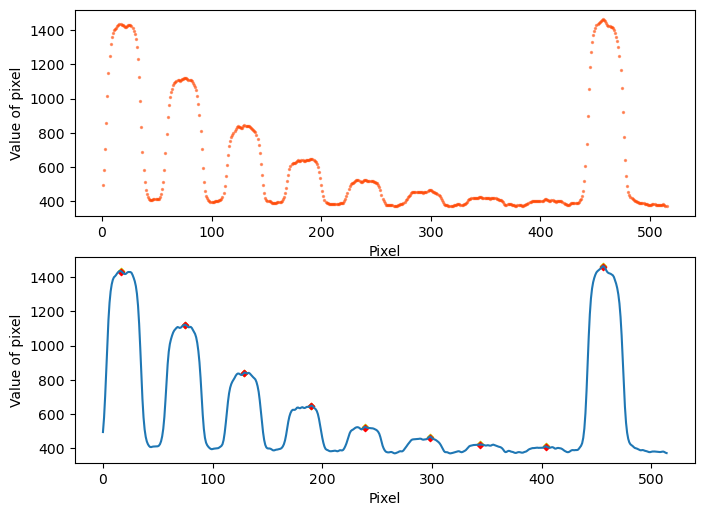

In [23]:
shape1 = o_call10s.shape[1]
shape0 = o_call10s.shape[0]

x1= int((0.322) * shape1)
y1= int((1-0.509) * shape0)
x2= int((0.594) * shape1)
y2= int((1-0.619) * shape0)
x3= int((0.631) * shape1)
y3= int((1-0.529) * shape0)
x4= int((0.358) * shape1)
y4= int((1-0.418) * shape0)

image_10s,mean_10s= subimage_preob_2('/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_10s_XVI-1.fit.fits.jpg',o_call10s,x1,y1,x2,y2,x3,y3,x4,y4)
peak_indexes_10s,peak_mean_10s = graf(mean_10s,21)


уехала домой, слишком много чихаю

165.77850523460907
-14.22149476539093


<ipython-input-18-8320d7e59a14>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'maxima')


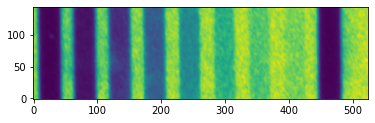

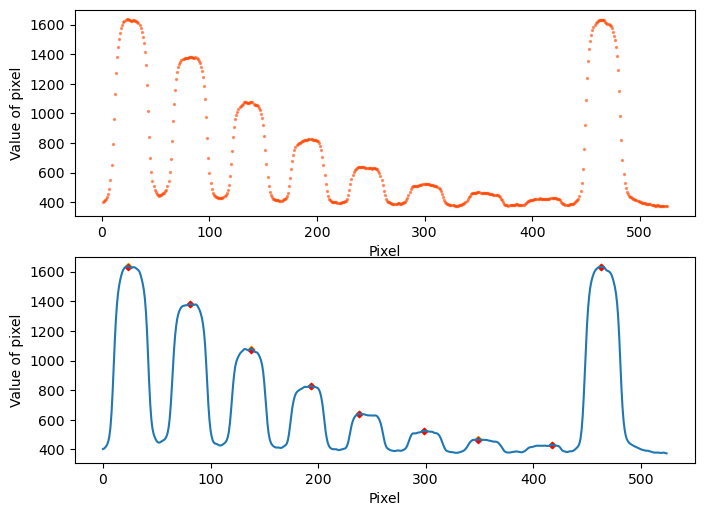

In [24]:
shape1 = o_call15s.shape[1]
shape0 = o_call15s.shape[0]

x1= int((0.353) * shape1)
y1= int((1-0.552) * shape0)
x2= int((0.631) * shape1)
y2= int((1-0.658) * shape0)
x3= int((0.671) * shape1)
y3= int((1-0.554) * shape0)
x4= int((0.393) * shape1)
y4= int((1-0.448) * shape0)

image_15s,mean_15s= subimage_preob_2('/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_15s_XVI-1.fit.fits.jpg',o_call15s,x1,y1,x2,y2,x3,y3,x4,y4)
peak_indexes_15s,peak_mean_15s = graf(mean_15s,21)


-165.96375653207352
14.036243467926482


<ipython-input-18-8320d7e59a14>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'maxima')


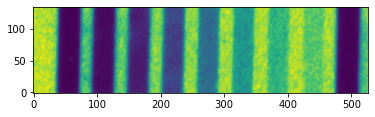

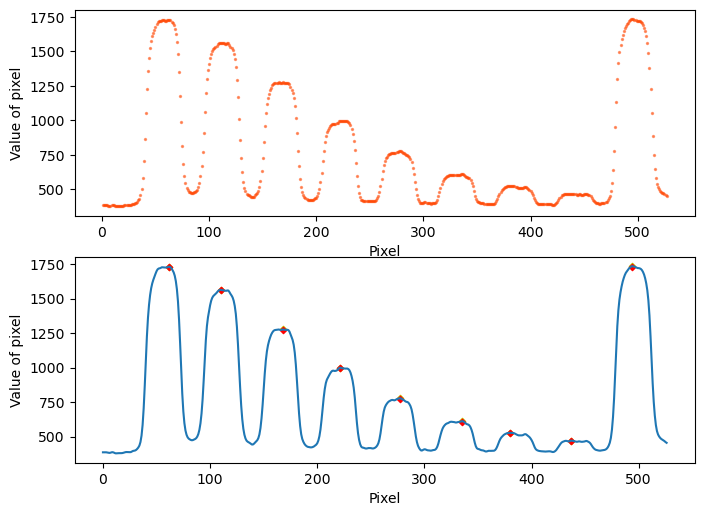

In [25]:
shape1 = o_call20s.shape[1]
shape0 = o_call20s.shape[0]

x1= int((0.397) * shape1)
y1= int((1-0.612) * shape0)
x2= int((0.677) * shape1)
y2= int((1-0.506) * shape0)
x3= int((0.64) * shape1)
y3= int((1-0.409) * shape0)
x4= int((0.36) * shape1)
y4= int((1-0.515) * shape0)

image_20s,mean_20s= subimage_preob_2('/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_20s_XVI-1.fit.fits.jpg',o_call20s,x1,y1,x2,y2,x3,y3,x4,y4)
peak_indexes_20s,peak_mean_20s = graf(mean_20s,21)


-165.43184813084562
14.568151869154377


<ipython-input-18-8320d7e59a14>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'maxima')


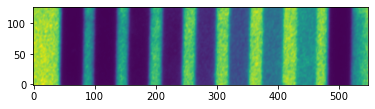

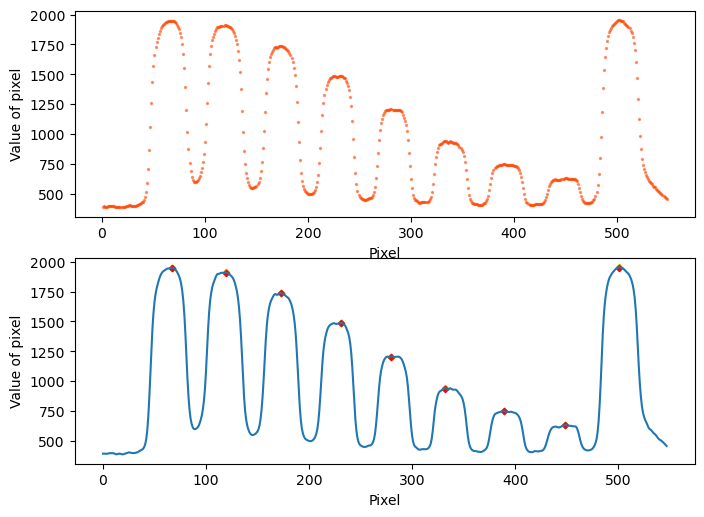

In [26]:
shape1 = o_call40s.shape[1]
shape0 = o_call40s.shape[0]

x1= int((0.387) * shape1)
y1= int((1-0.628) * shape0)
x2= int((0.677) * shape1)
y2= int((1-0.514) * shape0)
x3= int((0.641) * shape1)
y3= int((1-0.423) * shape0)
x4= int((0.351) * shape1)
y4= int((1-0.537) * shape0)

image_40s,mean_40s= subimage_preob_2('/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_40s_XVI-1.fit.fits.jpg',o_call40s,x1,y1,x2,y2,x3,y3,x4,y4)
peak_indexes_40s,peak_mean_40s = graf(mean_40s,21)


-166.56897112931836
13.431028870681644


<ipython-input-18-8320d7e59a14>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'maxima')


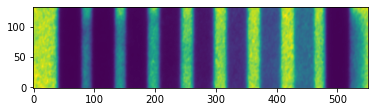

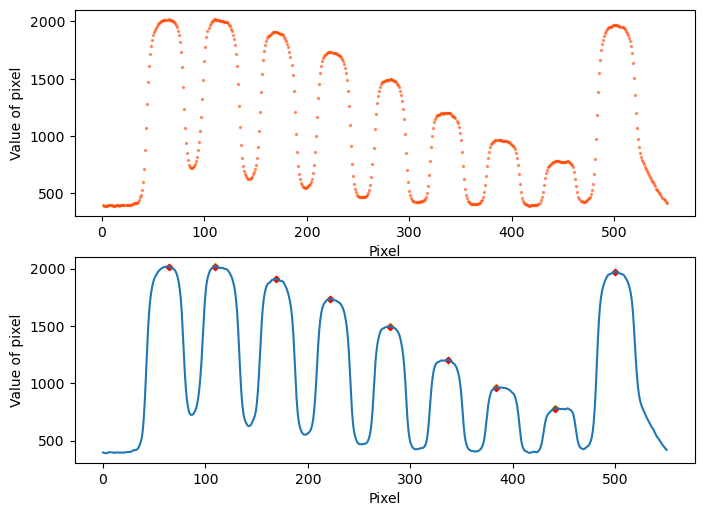

In [27]:
shape1 = o_call60s.shape[1]
shape0 = o_call60s.shape[0]

x1= int((0.407) * shape1)
y1= int((1-0.662) * shape0)
x2= int((0.7) * shape1)
y2= int((1-0.557) * shape0)
x3= int((0.665) * shape1)
y3= int((1-0.46) * shape0)
x4= int((0.372) * shape1)
y4= int((1-0.566) * shape0)

image_60s,mean_60s= subimage_preob_2('/home/adel/Astro/Galaxies/xvi-1-3200DPI/fits/Calibrovka_25-26.01.1976_60s_XVI-1.fit.fits.jpg',o_call60s,x1,y1,x2,y2,x3,y3,x4,y4)
peak_indexes_60s,peak_mean_60s = graf(mean_60s,21)


In [28]:
delta_m1 = 2.5*np.log(60/15)
delta_m2 = 2.5*np.log(60/17)
delta_m3 = 2.5*np.log(60/25)
delta_m4 = 2.5*np.log(60/29)
delta_m5 = 2.5*np.log(60/35)
delta_m6 = 2.5*np.log(60/47)
delta_m7 = 2.5*np.log(60/60)
print(len(peak_mean_3s))
print(len(peak_mean_5s))
print(len(peak_mean_10s))
print(len(peak_mean_15s))
print(len(peak_mean_20s))
print(len(peak_mean_40s))
print(len(peak_mean_60s))

9
9
9
9
9
9
9


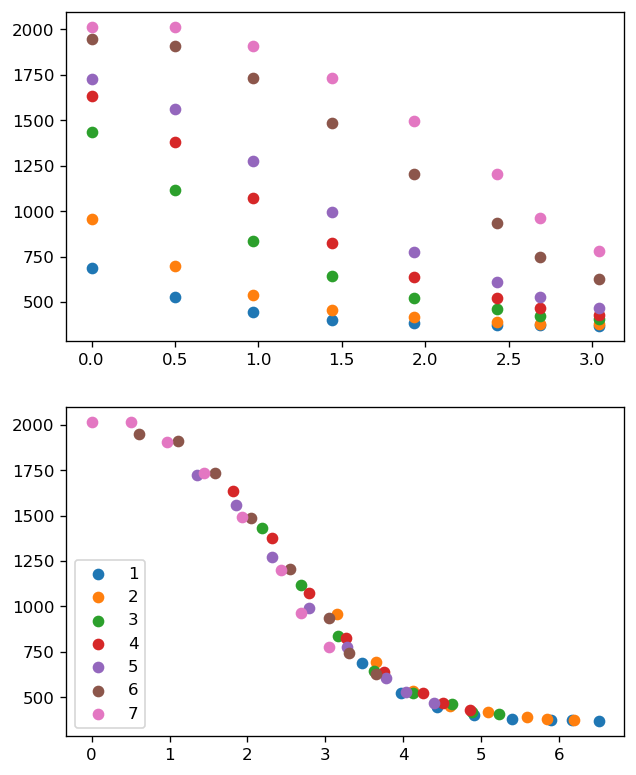

In [29]:
fig = plt.figure(figsize=(6,8),dpi=120)
ax1 = fig.add_subplot(2,1,1)
ax1.scatter(mag_after_1972[:-1],peak_mean_3s[:-1], label=1)
ax1.scatter(mag_after_1972[:-1],peak_mean_5s[:-1], label=2)
ax1.scatter(mag_after_1972[:-1],peak_mean_10s[:-1],label=3)
ax1.scatter(mag_after_1972[:-1],peak_mean_15s[:-1],label=4)
ax1.scatter(mag_after_1972[:-1],peak_mean_20s[:-1],label=5)
ax1.scatter(mag_after_1972[:-1],peak_mean_40s[:-1],label=6)
ax1.scatter(mag_after_1972[:-1],peak_mean_60s[:-1],label=7)


ax2 = fig.add_subplot(2,1,2)
ax2.scatter(mag_after_1972[:-1]+delta_m1,peak_mean_3s[:-1], label=1)
ax2.scatter(mag_after_1972[:-1]+delta_m2,peak_mean_5s[:-1], label=2)
ax2.scatter(mag_after_1972[:-1]+delta_m3,peak_mean_10s[:-1],label=3)
ax2.scatter(mag_after_1972[:-1]+delta_m4,peak_mean_15s[:-1],label=4)
ax2.scatter(mag_after_1972[:-1]+delta_m5,peak_mean_20s[:-1],label=5)
ax2.scatter(mag_after_1972[:-1]+delta_m6,peak_mean_40s[:-1],label=6)
ax2.scatter(mag_after_1972[:-1]+delta_m7,peak_mean_60s[:-1],label=7)
plt.legend(loc=3)


In [30]:
array = [peak_mean_3s[:-1],peak_mean_5s[:-1],peak_mean_10s[:-1],peak_mean_15s[:-1],peak_mean_20s[:-1],peak_mean_40s[:-1],peak_mean_60s[:-1]]
y_array = np.concatenate(array)
x_array = np.concatenate([mag_after_1972[:-1]+delta_m1,mag_after_1972[:-1]+delta_m2,mag_after_1972[:-1]+delta_m3,mag_after_1972[:-1]+delta_m4,mag_after_1972[:-1]+delta_m5,mag_after_1972[:-1]+delta_m6,mag_after_1972[:-1]+delta_m7])

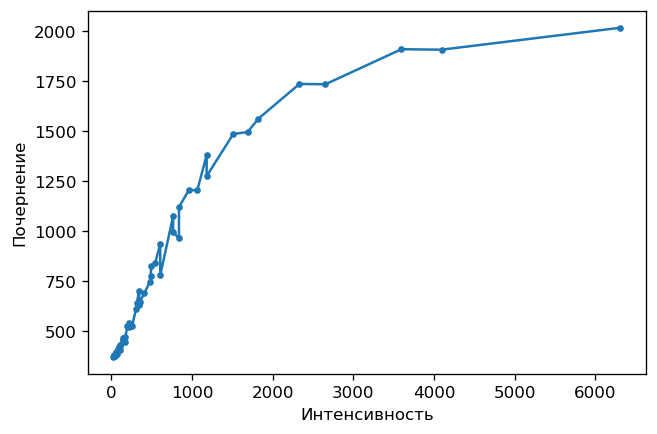

In [31]:
xarray_flux, y_array = mean_deviation(x_array,y_array)

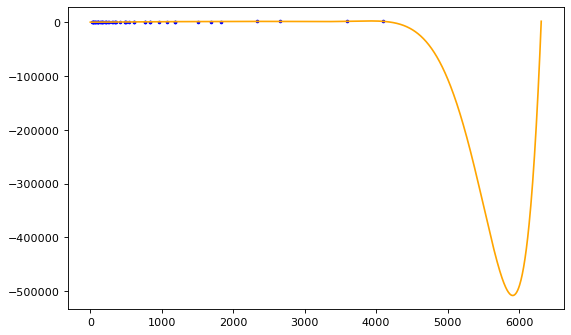

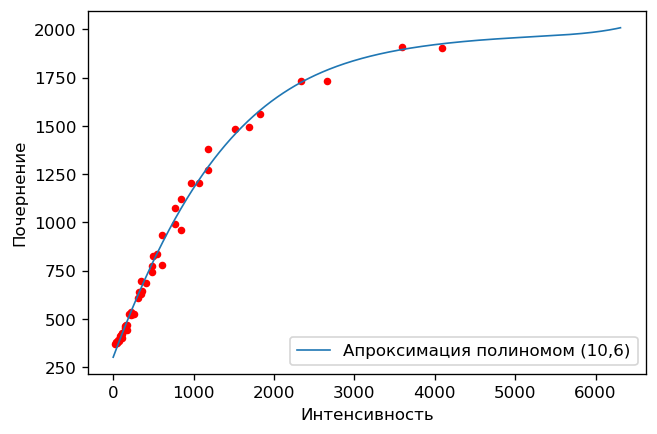

In [32]:
xpp,polinomial = aprx1(xarray_flux,y_array,7)

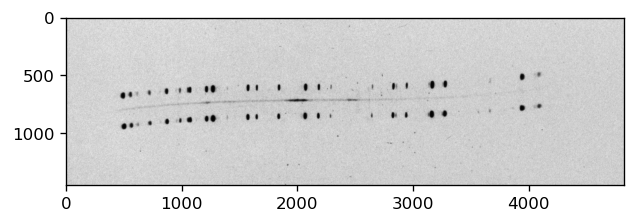

In [33]:
fits_Mr3 = fits.open('new_specHB/5121.fit')
data_Mr3  = fits_Mr3[0].data
plt.figure(figsize=(6,4),dpi=120)
plt.imshow(data_Mr3, cmap='gray')
# plt.axis("off")
plt.imsave("data_Mr3.jpg",data_Mr3)

177.0185387800178
-2.981461219982208


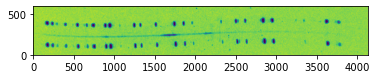

In [34]:
shape1 = data_Mr3.shape[1]
shape0 = data_Mr3.shape[0]

x1= int((0.036) * shape1)
y1= int((1-0.584) * shape0)
x2= int((0.891) * shape1)
y2= int((1-0.732) * shape0)
x3= int((0.953) * shape1)
y3= int((1-0.374) * shape0)
x4= int((0.098) * shape1)
y4= int((1-0.226) * shape0)
# data_Mr3 = fits2png("/home/adel/Astro/Galaxies/xvi-1-3200DPI/fit/Mr3_25-26.01.1976_6m_XVI-1-6.fit.fits")

# data1_Mr3 = np.array(data_Mr3)
image_Mr3,mean_Mr3= subimage_preob_2('data_Mr3.jpg',data_Mr3,x1,y1,x2,y2,x3,y3,x4,y4)
# peak_indexes_60s,peak_mean_60s = graf(mean_60s,21)


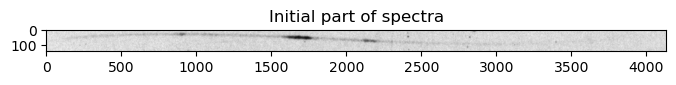

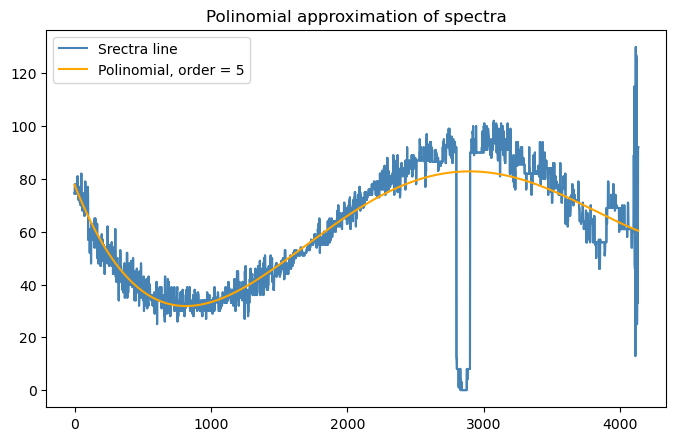

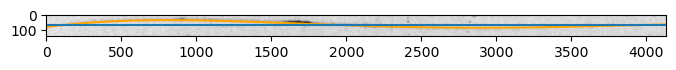

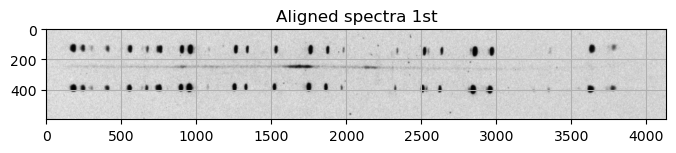

In [35]:
spectra_Mr3= polynomial_alighn(image_Mr3,190,330,5)

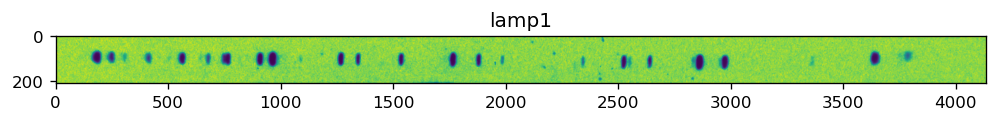

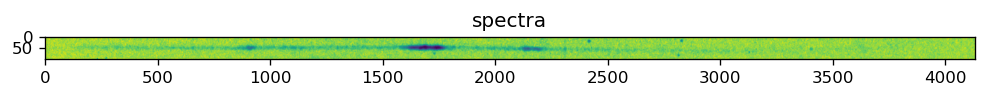

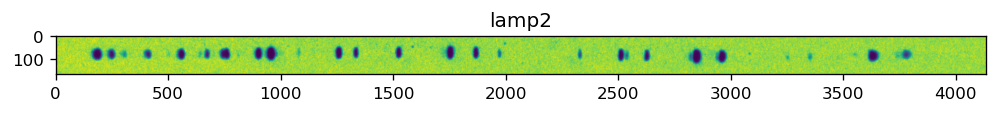

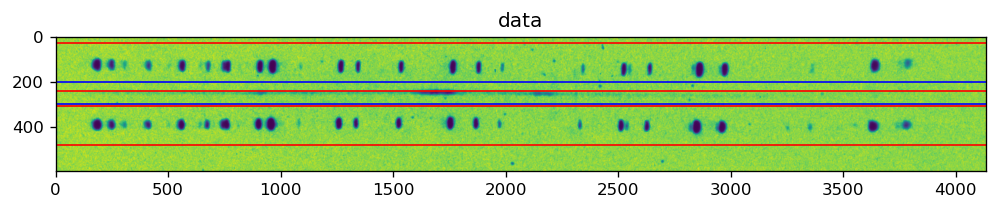

In [36]:
lamp_mr3, spectra_mr3, lamp_m3 = spectra_lamps(spectra_Mr3,30,240,200,300,310,480)

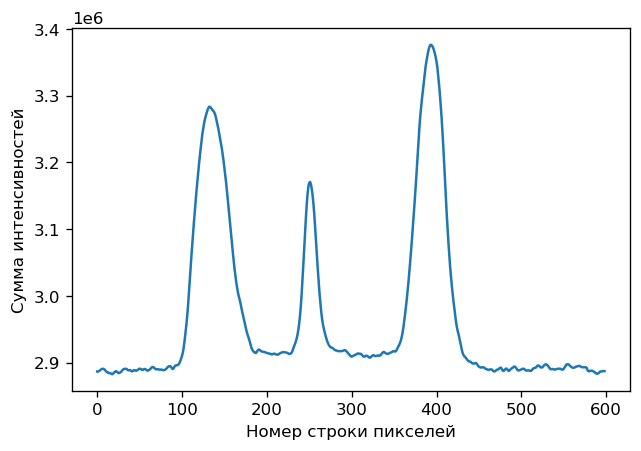

In [37]:
spectra_mr3_preob = preob_spectra(spectra_Mr3)

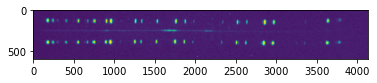

In [38]:
plt.imshow(spectra_mr3_preob)

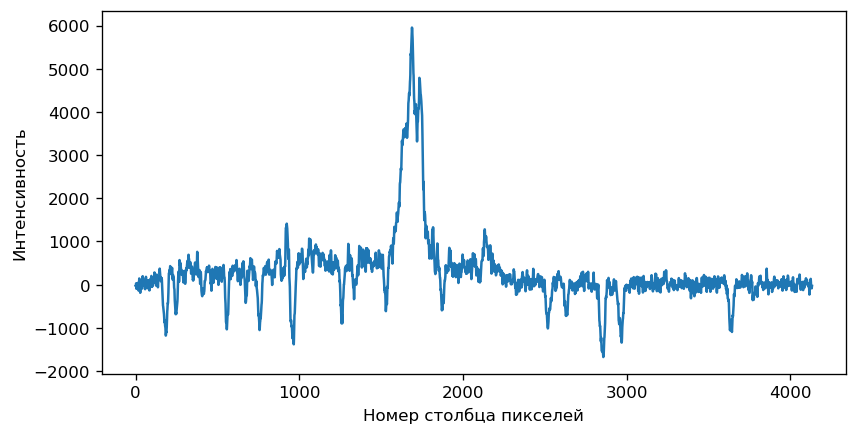

In [39]:
spectrum_final = spectra_background(spectra_mr3_preob,240,250)

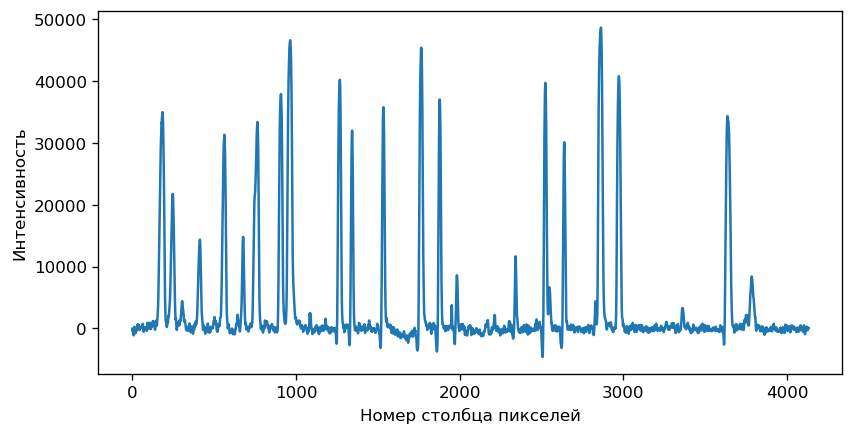

In [40]:
spectrum_final_lamp1_mr3= spectra_background(spectra_mr3_preob,100,180)
# plt.axhline(spectrum_final_lamp1.mean())

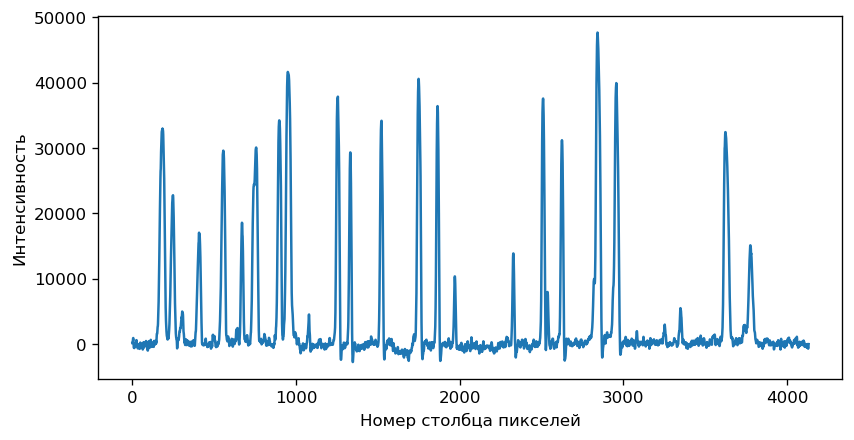

In [41]:
spectrum_final_lamp2_mr3= spectra_background(spectra_mr3_preob,360,440)
# plt.axhline(spectrum_final_lamp1.mean())

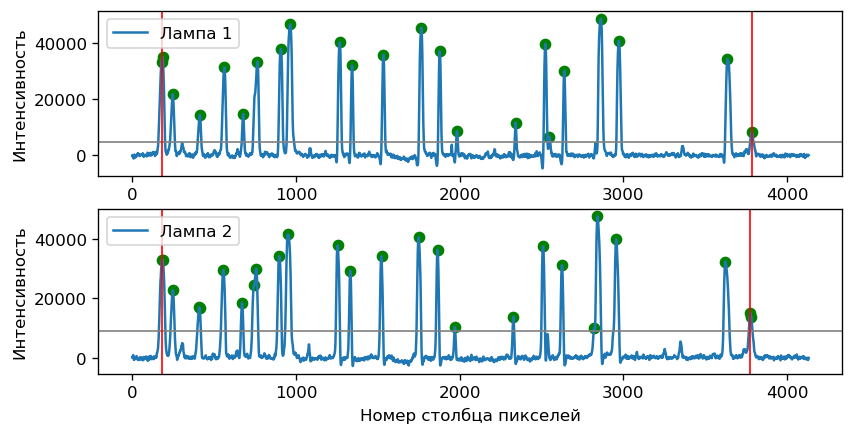

In [42]:
index_1,index_2,index_l1,index_l2 = x_axis_to_wavelenght(spectrum_final_lamp1_mr3,spectrum_final_lamp2_mr3)

In [59]:
print(index_l1)
for u in range(0,len(index_l1)):
    index_l1corr = index_l1[1:u]
# print(index_l1corr)

[179, 185, 248, 413, 563, 677, 765, 908, 965, 1268, 1343, 1534, 1766, 1878, 1984, 2342, 2523, 2548, 2639, 2863, 2973, 3636, 3784]


In [44]:
print(index_l2)

[184, 186, 249, 408, 411, 556, 670, 744, 757, 898, 950, 1256, 1332, 1523, 1749, 1865, 1970, 2328, 2510, 2625, 2822, 2842, 2957, 3624, 3776, 3781]


6164.250709363712


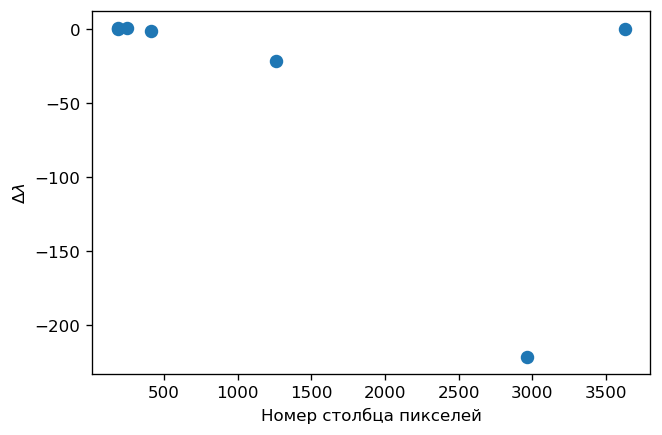

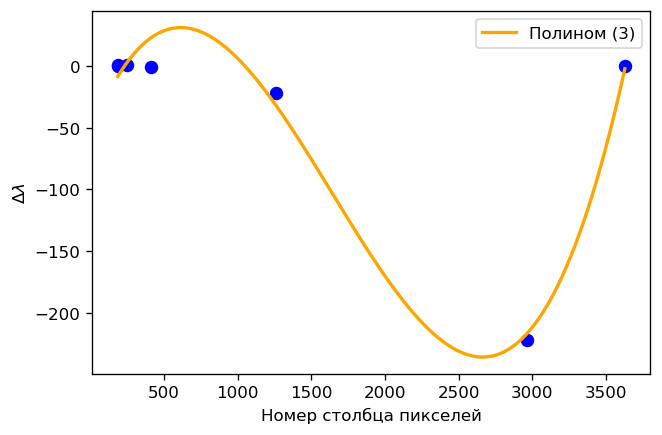

In [57]:
x1 = int(np.mean([185,184]))############ 
x2 = int(np.mean([248,249]))############
x3 = int(np.mean([413,411]))############
x4 = int(np.mean([1268,1256]))
x5 = int(np.mean([2973,2957]))
x6 = int(np.mean([2973,2957]))########



lambd_1 = 6143.06######################
lambd_2 = 6163.5939######################
lambd_3 = 6217.2813######################
lambd_4 = 6506.5279
lambd_5 = 7245.167
lambd_6 = 7245.167###########


wv,pp = func(185,3630,x1,x2,x3,x4,x5,lambd_1,lambd_2,lambd_3,lambd_4,lambd_5,wavelenght)

In [58]:
wavelenght

[6085.813456793554,
 6086.1297360377885,
 6086.446015282023,
 6086.762294526257,
 6087.078573770492,
 6087.394853014726,
 6087.711132258961,
 6088.027411503196,
 6088.343690747431,
 6088.659969991665,
 6088.9762492359,
 6089.292528480134,
 6089.6088077243685,
 6089.925086968603,
 6090.241366212837,
 6090.557645457072,
 6090.873924701306,
 6091.190203945541,
 6091.506483189775,
 6091.82276243401,
 6092.139041678244,
 6092.455320922479,
 6092.771600166713,
 6093.087879410948,
 6093.404158655182,
 6093.7204378994165,
 6094.036717143651,
 6094.352996387886,
 6094.669275632121,
 6094.985554876355,
 6095.30183412059,
 6095.618113364824,
 6095.934392609059,
 6096.250671853293,
 6096.566951097528,
 6096.883230341762,
 6097.199509585997,
 6097.515788830231,
 6097.8320680744655,
 6098.1483473187,
 6098.464626562934,
 6098.780905807169,
 6099.097185051403,
 6099.413464295638,
 6099.729743539872,
 6100.046022784107,
 6100.362302028341,
 6100.678581272576,
 6100.994860516811,
 6101.3111397610455,
 

In [46]:
index_2

3780

Text(0, 0.5, 'Интенсивность')

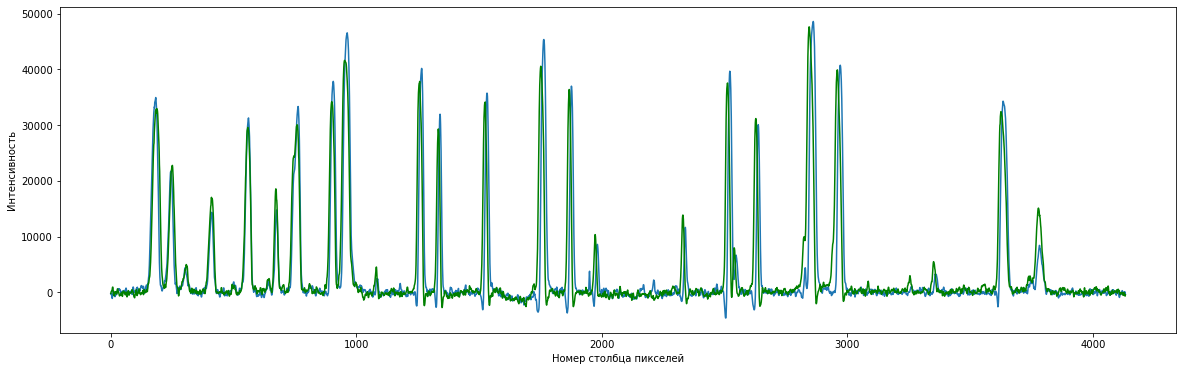

In [47]:
plt.figure(figsize=(20,6))
plt.plot(np.roll(spectrum_final_lamp1_mr3,-2),label="Лампа 1")
plt.plot(np.roll(spectrum_final_lamp2_mr3,2),c="g",label="Лампа 2")
plt.xlabel("Номер столбца пикселей")
plt.ylabel("Интенсивность")
# plt.savefig("roll_lamps.jpg")

In [48]:
lambd_0 = 6143.06
lambd_n = 7281.349

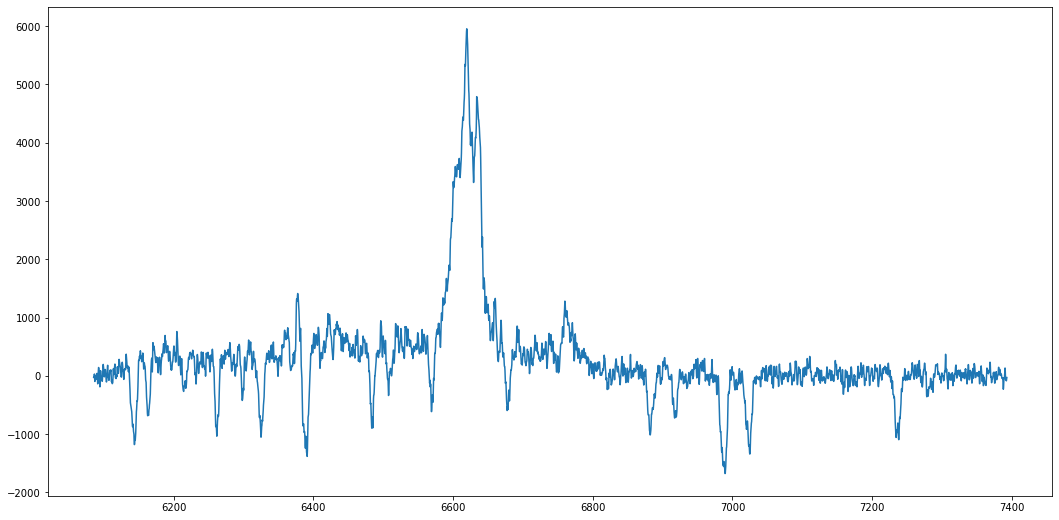

In [49]:
wavelenght,dispersion = pixel2wavelenght(spectrum_final,lambd_0,lambd_n,181,3)

In [50]:
dispersion

0.31627924423450954

In [20]:
with open('files_lamps/HeArNe.txt') as f:
    lines = f.readlines()

In [31]:
wvl = []
intens = []
for line in lines:
    line = line.split("  ")
    #print(line)
    wvl.append(float(line[0].strip()))
    intens.append(float(line[1].strip()))    

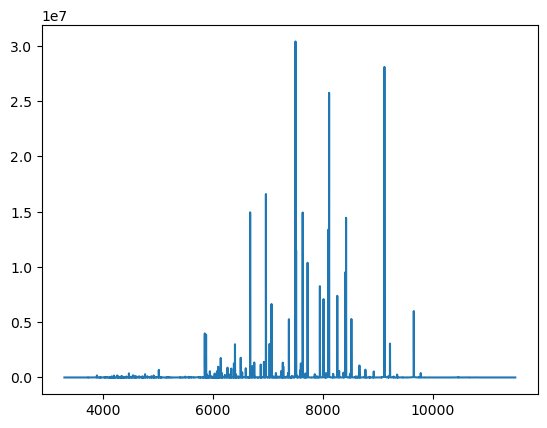

In [33]:
plt.plot(wvl,intens)

In [51]:
wvl_arr = np.array(wvl)
intens_arr = np.array(intens)


In [57]:
array = [wvl_arr,intens_arr]
iraf_lamps = np.concatenate((wvl_arr,intens_arr))

LLLLLEEEEEENNNNNN:  96


(5700.0, 8000.0)

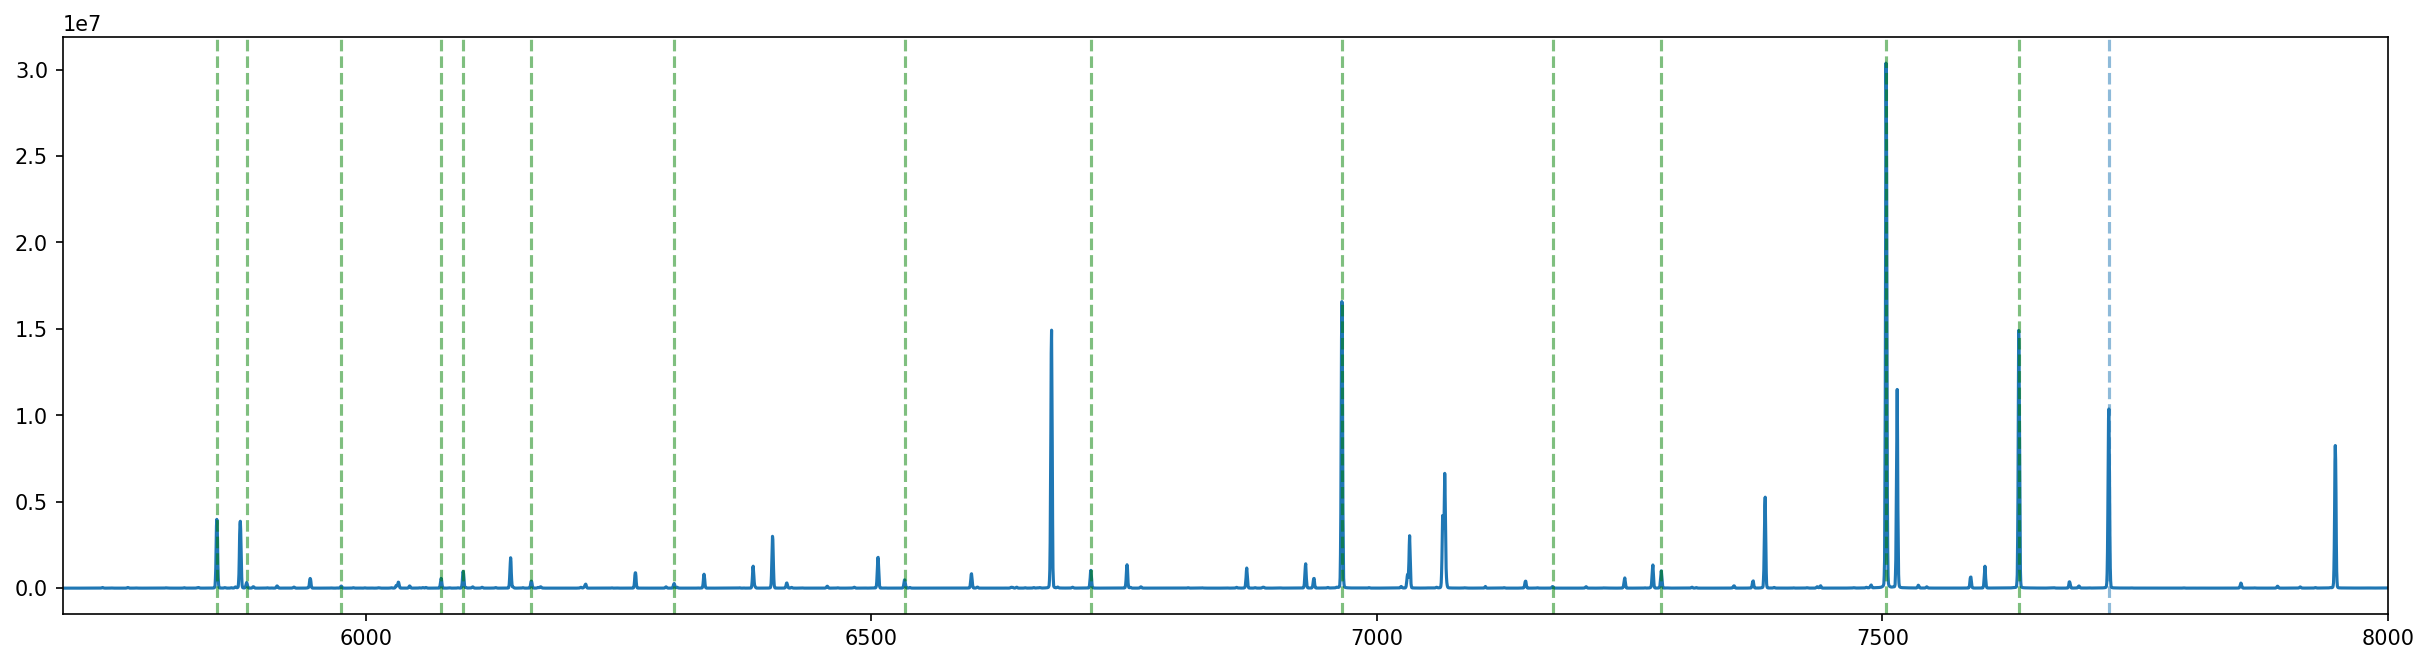

In [154]:
peak_indexes = signal.argrelextrema(intens_arr, np.greater, order=120)[0]
print("LLLLLEEEEEENNNNNN: ",len(peak_indexes))
peak_ind_wvl = []
peak_ind_intens = []

for i in peak_indexes:
    peak_ind_wvl.append(wvl[i])
    peak_ind_intens.append(intens[i])

plt.figure(figsize=(20,5),dpi=150)
plt.plot(wvl_arr,intens_arr)
#plt.gca().invert_xaxis()
#plt.scatter(peak_ind_wvl,peak_ind_intens)
#plt.axhline(0.1e7,c="r")
plt.axvline(5852.49,c="green",alpha=0.5,linestyle="--")
plt.axvline(5881.90,c="green",alpha=0.5,linestyle="--")
plt.axvline(5975.53,c="green",alpha=0.5,linestyle="--")
plt.axvline(6074.34,c="green",alpha=0.5,linestyle="--")
plt.axvline(6096.16,c="green",alpha=0.5,linestyle="--")
plt.axvline(6163.59,c="green",alpha=0.5,linestyle="--")
plt.axvline(6304.79,c="green",alpha=0.5,linestyle="--")
plt.axvline(6532.88,c="green",alpha=0.5,linestyle="--")
plt.axvline(6717.04,c="green",alpha=0.5,linestyle="--")
plt.axvline(6965.49,c="green",alpha=0.5,linestyle="--")
plt.axvline(7173.94,c="green",alpha=0.5,linestyle="--")
plt.axvline(7281.35,c="green",alpha=0.5,linestyle="--")
plt.axvline(7503.87,c="green",alpha=0.5,linestyle="--")
plt.axvline(7635.11,c="green",alpha=0.5,linestyle="--")
plt.axvline(7724,alpha=0.5,linestyle="--")

plt.xlim(5700,8000)